# Applying classifiers to Shalek2013

We're going to use the classifier knowledge that we've learned so far and apply it to the shalek2013 and macaulay2016 datasets.

For the GO analysis, we'll need a few other packages:

* `mygene` for looking up the gene ontology categories of genes
* `goatools` for performing gene ontology enrichment analysis
* `fishers_exact_test` for `goatools`

Use the following commands at your terminal to install the packages. Some of them are on Github so it's important to get the whole command right.

```
$ pip install mygene
$ pip install git+git://github.com/olgabot/goatools.git
$ pip install git+https://github.com/brentp/fishers_exact_test.git
```

In [1]:
# Alphabetical order is standard
# We're doing "import superlongname as abbrev" for our laziness - this way we don't have to type out the whole thing each time.

# From python standard library
import collections

# Python plotting library
import matplotlib.pyplot as plt

# Numerical python library (pronounced "num-pie")
import numpy as np

# Dataframes in Python
import pandas as pd

# Statistical plotting library we'll use
import seaborn as sns
sns.set(style='whitegrid')

# Label processing
from sklearn import preprocessing

# Matrix decomposition
from sklearn.decomposition import PCA, FastICA

# Matrix decomposition
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Manifold learning
from sklearn.manifold import MDS, TSNE

# Gene ontology
import goatools
import mygene

# This is necessary to show the plotted figures inside the notebook -- "inline" with the notebook cells
%matplotlib inline


/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Utility functions for gene ontology and SVM decision boundary plotting

In [2]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([[xi, yj]])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
GO_KEYS = 'go.BP', 'go.MF', 'go.CC'

def parse_mygene_output(mygene_output):
    """Convert mygene.querymany output to a gene id to go term mapping (dictionary)
    
    Parameters
    ----------
    mygene_output : dict or list
        Dictionary (returnall=True) or list (returnall=False) of 
        output from mygene.querymany
        
    Output
    ------
    gene_name_to_go : dict
        Mapping of gene name to a set of GO ids    
    """
    # if "returnall=True" was specified, need to get just the "out" key
    if isinstance(mygene_output, dict):
        mygene_output = mygene_output['out']

    gene_name_to_go = collections.defaultdict(set)

    for line in mygene_output:
        gene_name = line['query']
        for go_key in GO_KEYS:
            try:
                go_terms = line[go_key]
            except KeyError:
                continue
            if isinstance(go_terms, dict):
                go_ids = set([go_terms['id']])
            else:
                go_ids = set(x['id'] for x in go_terms)
            gene_name_to_go[gene_name] |= go_ids
    return gene_name_to_go


## Read in the Shalek2013 data

In [3]:
metadata = pd.read_csv('../data/shalek2013/metadata.csv', 
                               
                                     # Sets the first (Python starts counting from 0 not 1) column as the row names
                                      index_col=0)
expression = pd.read_csv('../data/shalek2013/expression.csv', 
                               
                                     # Sets the first (Python starts counting from 0 not 1) column as the row names
                                      index_col=0)
expression_feature = pd.read_csv('../data/shalek2013/expression_feature.csv', 
                               
                                     # Sets the first (Python starts counting from 0 not 1) column as the row names
                                      index_col=0)

# creating new column indicating color
metadata['color'] = metadata['maturity'].map(
    lambda x: 'MediumTurquoise' if x == 'immature' else 'Teal')
metadata.loc[metadata['pooled'], 'color'] = 'black'

# Create a column indicating both maturity and pooled for coloring with seaborn, e.g. sns.pairplot
metadata['group'] = metadata['maturity']
metadata.loc[metadata['pooled'], 'group'] = 'pooled'

# Create a palette and ordering for using with sns.pairplot
palette = ['MediumTurquoise', 'Teal', 'black']
order = ['immature', 'mature', 'pooled']

metadata

,phenotype,pooled,outlier,maturity,color,group
S1,BDMC,False,False,immature,MediumTurquoise,immature
S2,BDMC,False,False,immature,MediumTurquoise,immature
S3,BDMC,False,False,immature,MediumTurquoise,immature
S4,BDMC,False,False,immature,MediumTurquoise,immature
S5,BDMC,False,False,immature,MediumTurquoise,immature
S6,BDMC,False,False,immature,MediumTurquoise,immature
S7,BDMC,False,False,immature,MediumTurquoise,immature
S8,BDMC,False,False,immature,MediumTurquoise,immature
S9,BDMC,False,False,immature,MediumTurquoise,immature
S10,BDMC,False,False,immature,MediumTurquoise,immature


### Side note: getting LPS response genes using `query`

Get the "LPS response genes" using a query:

In [4]:
subset = expression_feature.query('gene_category == "LPS Response"')
subset.head()

,gene_category
1110018G07RIK,LPS Response
1110032F04RIK,LPS Response
1110038F14RIK,LPS Response
1190002H23RIK,LPS Response
1200009I06RIK,LPS Response


Assign the variable `lps_response_genes` based on the gene ids pulled out from this subset:

In [5]:
lps_response_genes = subset.index
lps_response_genes

Index(['1110018G07RIK', '1110032F04RIK', '1110038F14RIK', '1190002H23RIK',
       '1200009I06RIK', '1600014C10RIK', '1810029B16RIK', '2010002M12RIK',
       '2200002D01RIK', '2210009G21RIK',
       ...
       'ZCCHC2', 'ZCCHC6', 'ZDHHC21', 'ZFP36', 'ZFP558', 'ZFP800', 'ZFP811',
       'ZHX2', 'ZNFX1', 'ZUFSP'],
      dtype='object', length=945)

For this analysis We want to compare the difference between the "mature" and "immature" cells in the Shalek2013 data.

In [6]:
singles_ids = [x for x in expression.index if x.startswith('S')]
singles = expression.loc[singles_ids]
singles.shape

(18, 6312)

Use only the genes that are substantially expressed in single cells

In [7]:
singles = singles.loc[:, (singles > 1).sum() >= 3]
singles.shape

(18, 6013)

Now because computers only understand numbers, we'll convert the category label of "mature" and "immature" into integers to a using a `LabelEncoder`. Let's look at that column again, only for mature cells:

In [8]:
singles_maturity = metadata.loc[singles.index, 'maturity']
singles_maturity

S1     immature
S2     immature
S3     immature
S4     immature
S5     immature
S6     immature
S7     immature
S8     immature
S9     immature
S10    immature
S11    immature
S12      mature
S13      mature
S14    immature
S15    immature
S16      mature
S17    immature
S18    immature
Name: maturity, dtype: object

In [9]:
# Instantiate the encoder
encoder = preprocessing.LabelEncoder()

# Get number of categories and transform "mature"/"immature" to numbers
target = encoder.fit_transform(singles_maturity)
target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0])

## Run the classifier!!

Yay so now we can run a classifier!

In [10]:
from sklearn.svm import SVC

classifier = SVC(kernel='linear')
classifier.fit(singles, target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

We'll use PCA or ICA to reduce our data for visualizing the SVM decision boundary. Stick to 32 or fewer components because the next steps will die if you use more than 32. Also, this `n_components` variable will be used later so pay attention :)

In [174]:
n_components = 2

smusher = PCA(n_components=n_components)
smushed = pd.DataFrame(smusher.fit_transform(singles), index=singles.index)
print(smushed.shape)
smushed.head()

# Let's add the group identifier here for plotting:

smushed_with_group = smushed.join(metadata['group'])
print(smushed_with_group.shape)
smushed_with_group.head()

(18, 2)
(18, 3)


,0,1,group
S1,-50.895164,51.051727,immature
S2,-6.621843,-16.845237,immature
S3,-27.129347,-13.530018,immature
S4,-23.018061,-34.946561,immature
S5,-29.971542,-1.820914,immature


/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


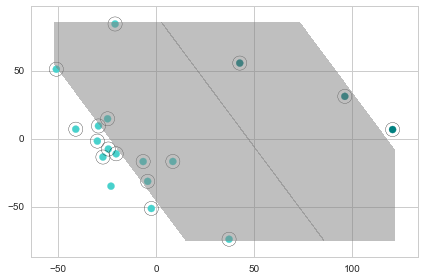

In [185]:

n_intervals = 50
x_min, x_max = smushed[0].min() - 1, smushed[0].max() + 1
y_min, y_max = smushed[1].min() - 1, smushed[1].max() + 1
X = np.linspace(x_min, x_max, n_intervals)
Y = np.linspace(y_min, y_max, n_intervals)
xx, yy = np.meshgrid(X, Y)

# Get the decision boundary
# Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])

two_d_space = np.c_[xx.ravel(), yy.ravel()]
gene_space = smusher.inverse_transform(two_d_space)
Z = classifier.decision_function(gene_space)
Z = Z.reshape(xx.shape)

support_vectors_smushed = pd.DataFrame(smusher.transform(classifier.support_vectors_))

fig, ax = plt.subplots()

# ax.scatter(smushed_intervals[0], smushed_intervals[1], color='pink')
ax.scatter(smushed[0], smushed[1], color=metadata['color'], s=50)
ax.scatter(support_vectors_smushed[0], support_vectors_smushed[1], s=200, facecolors='none')
ax.contourf(X, Y, Z, colors='grey',
           levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

That looks really cool! Almost ALL the data points are support vectors (except that one cell). Why do you think so?

This was nice but how do we *biologically* assess our classifiers? We want to do that using our biological knowledge of the data. Let's first look at the distribution of the coefficients in the data. This is the coefficient assigned to each feature. We'll first make it a Series so it's easy to work with (it's currently a numpy array).

In [192]:
coefficients = pd.Series(classifier.coef_.flat, index=singles.columns)
coefficients.head()

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/pandas/types/dtypes.py:127: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':


NPL        -1.387786e-04
QK          1.543810e-04
AK163153    3.543145e-04
AGPAT4     -4.594230e-04
IGF2R       2.282964e-07
dtype: float64

Now let's plot the distribution of the coefficients across all featurs:

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


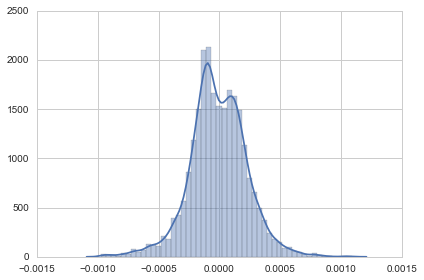

In [186]:
sns.distplot(coefficients)

This is semi-gaussian .. what does that mean? It means that most of the features in the dataset don't actually help you tell the difference between the datasets.

Let's get the features which are 2 std devs away from the mean of the data. Let's plot what that would look like

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


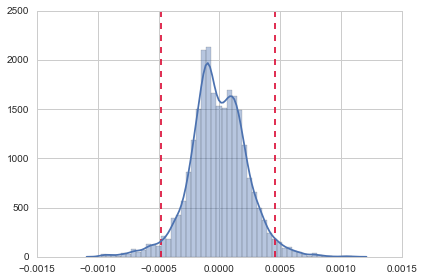

In [195]:
mean = coefficients.mean()
std = coefficients.std()
multiplier = 2
lower_cutoff = mean - multiplier * std
upper_cutoff = mean + multiplier * std

fig, ax = plt.subplots()
sns.distplot(coefficients)

# Add vertical lines
ymin, ymax = ax.get_ylim()
ax.vlines([lower_cutoff, upper_cutoff], ymin, ymax, linestyle='--', color='Crimson')

In [197]:
below_cutoff = coefficients[coefficients < lower_cutoff]
print(below_cutoff.shape)
below_cutoff.head()

(172,)


FPR1    -0.000507
FPR2    -0.000580
PRDX6   -0.000543
MYO1F   -0.000872
TNF     -0.000727
dtype: float64

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


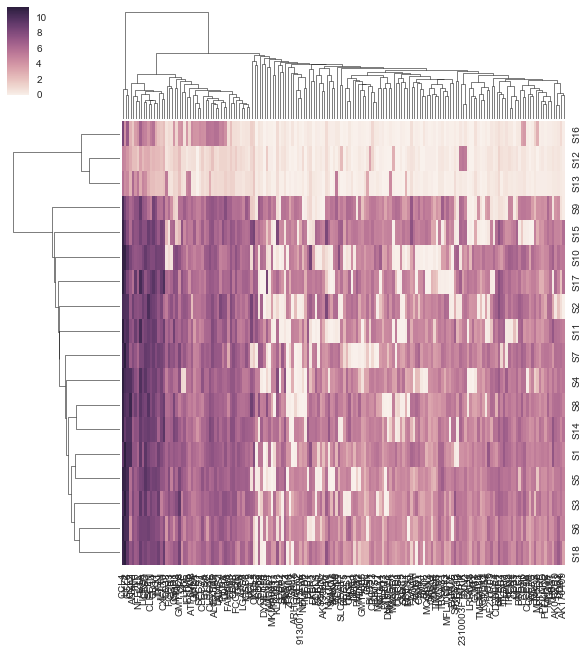

In [198]:
sns.clustermap(singles[below_cutoff.index])

### Exercise 1

Look 

## Evaluating classifiers through Gene Ontology (GO) Enrichment

Gene ontology is a tree (aka directed acyclic graph or "dag") of gene annotations. The topmost node is the most general, and the bottommost nodes are the most specific. Here is an example GO graph.

![](figures/example_go_graph.png)

Three GO Domains:

* Cellular Component (CC)
* Molecular Function (MF)
* Biological Process (BP)

### Perform GO enrichment analysis (GOEA)


#### GOEA Step 1: Download GO graph file of "obo" type (same for all species)

This will download the file `"go-basic.obo"` if it doesn't already exist. This only needs to be done once.

In [ ]:
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

# Show the filename
obo_fname

#### GOEA Step 2: Create the GO graph (same for all species)

In [ ]:
obo_dag = goatools.obo_parser.GODag(obo_file='go-basic.obo')

#### GOEA Step 3: Get gene ID to GO id mapping (species-specific and experiment-specific)

Here we are establishing the background for our GOEA. Defining your background is **very important** because, for example, tehre are lots of neural genes so if you use all human genes as background in your study of which genes are upregulated in Neuron Type X vs Neuron Type Y, you'll get a bunch of neuron genes (which is true) but not the smaller differences between X and Y. Typicall, you use *all expressed genes* as the background.

For our data, we can access all expressed genes very simply by getting the column names in the dataframe: `expression.columns`.

In [ ]:
# Initialize the "mygene.info" (http://mygene.info/) interface
mg = mygene.MyGeneInfo()

mygene_output = mg.querymany(expression.columns, 
                             scopes='symbol', fields=['go.BP', 'go.MF', 'go.CC'], species='mouse', 
                             returnall=True)

gene_name_to_go = parse_mygene_output(mygene_output)

#### GOEA Step 4: Create a GO enrichment calculator object `go_enricher` (species- and experiment-specific)

In this step, we are using the two objects we've created (`obo_dag` from Step 2 and `gene_name_to_go` from Step 3) plus the gene ids to create a `go_enricher` object

In [ ]:
go_enricher = goatools.GOEnrichmentStudy(expression.columns, gene_name_to_go, obo_dag)

#### GOEA Step 5: Calculate go enrichment!!! (species- and experiment-specific)

Now we are ready to run go enrichment!! Let's take our enriched genes of interest and 

In [ ]:
genes_of_interest = 

results = go.run_study(genes[:5])

go_enrichment = pd.DataFrame([r.__dict__ for r in results])
go_enrichment.head()

In [ ]:
import pandas.util.testing as pdt

In [ ]:
pdt.assert_numpy_array_equal(two_d_space_v1, two_d_space_v2)

In [ ]:
two_d_space.shape

In [ ]:
plt.scatter(two_d_space[:, 0], two_d_space[:, 1], color='black')

In [ ]:
expression.index[:10]

In [ ]:
clf = ExtraTreesClassifier(n_estimators=100000, n_jobs=-1, verbose=1)

In [ ]:
expression.index.duplicated()

In [ ]:
expression.drop_duplicates()

In [ ]:
# assoc = pd.read_table('danio-rerio-gene-ontology.txt').dropna()
# assoc_df = assoc.groupby('Ensembl Gene ID').agg(lambda s: ';'.join(s))
# assoc_s = assoc_df['GO Term Accession'].apply(lambda s: set(s.split(';')))
# assoc_dict = assoc_s.to_dict()

In [ ]:
import goatools

# cl = gene_annotation.sort(col, ascending=False)[gene_annotation[col] > 5e-4].index
g = goatools.GOEnrichmentStudy(list(gene_annotation.index), assoc_dict, obo_dag, study=list(cl))

In [ ]:
for r in g.results[:25]:
    print r.goterm.id, '{:.2}'.format(r.p_bonferroni), r.ratio_in_study, r.goterm.name, r.goterm.namespace

In [ ]:
unsmushed = smusher.inverse_transform(two_d_space)

Z = classifier.decision_function(unsmushed)
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=target, cmap='Dark2')
ax.contour(X, Y, Z, colors='k',
           levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

### Exercise 1

1. Try the same analysis, but use ICA instead of PCA. 
    1. How does that change the classification? 
    2. How does it change the enriched genes?
    2. Are the cells closer or farther from the decision boundary? 
    3. Is that a "better" or "worse" classification? Why?
    4. Why does the reduction algorithm affect the visualization of the classification?
2. Could you use MDS or t-SNE for plotting of the classifier boundary? Why or why not?
3. Try the same analysis, but use the "LPS Response" genes and a dimensionality reduction algorithm of your choice. (... how do you subset only certain columns out of the dataframe?)
    1. How does that change the classification? 
    2. How does it change the enriched genes?
    2. Are the cells closer or farther from the decision boundary? 
    3. Is that a "better" or "worse" classification? Why?
4. For (1) and (2) above, also fry using radial basis kernel (`kernel="rbf"`) for SVC.
    1. How does that change the classification? 
    2. How does it change the enriched genes?
    2. Are the cells closer or farther from the decision boundary? 
    3. Is that a "better" or "worse" classification? Why?


## Decision trees

In [ ]:
def visualize_tree(estimator, X, y, smusher, boundaries=True,
                   xlim=None, ylim=None):
    estimator.fit(X, y)
    smushed = smusher.fit_transform(X)

    if xlim is None:
        xlim = (smushed[:, 0].min() - 0.1, smushed[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (smushed[:, 1].min() - 0.1, smushed[:, 1].max() + 0.1)

    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    two_d_space = np.c_[xx.ravel(), yy.ravel()]
    unsmushed = smusher.inverse_transform(two_d_space)
    Z = estimator.predict(unsmushed)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap='Paired')
    plt.clim(y.min(), y.max())

    # Plot also the training points
    plt.scatter(smushed[:, 0], smushed[:, 1], c=y, s=50, cmap='Paired')
    plt.axis('off')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        
    plt.clim(y.min(), y.max())
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i < 0:
            return

        tree = estimator.tree_
        
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i],
                            [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i],
                            [tree.threshold[i], xlim[1]], ylim)
        
        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim,
                            [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                            [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()


from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE, MDS


smusher = PCA(n_components=2)
# reduced_data = smusher.fit_transform(singles+1)

visualize_tree(classifier, singles, np.array(target), smusher)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
classifier = RandomForestClassifier()

smusher = PCA(n_components=2)
# reduced_data = smusher.fit_transform(singles+1)

visualize_tree(classifier, singles, np.array(target), smusher, boundaries=False)

In [ ]:
classifier = ExtraTreesClassifier()

smusher = PCA(n_components=2)
# reduced_data = smusher.fit_transform(singles+1)

visualize_tree(classifier, singles, np.array(target), smusher, boundaries=False)

### Macaulay2016

In [ ]:
pd.options.display.max_columns = 50

In [ ]:
macaulay2016_metadata = pd.read_csv('../4._Case_Study/macaulay2016/sample_info_qc.csv', index_col=0)
macaulay2016_metadata.head()

In [ ]:
macaulay2016_cluster_names = tuple(sorted(macaulay2016_metadata['cluster'].unique()))
macaulay2016_cluster_names

In [ ]:
macaulay2016_target = macaulay2016_metadata['cluster'].map(lambda x: macaulay2016_cluster_names.index(x))
macaulay2016_target

In [ ]:
macaulay2016_expression = pd.read_csv('../4._Case_Study/macaulay2016/gene_expression_s.csv', index_col=0).T


In [ ]:
macaulay2016_expression.head()

In [ ]:
macaulay2016_expression_filtered = macaulay2016_expression[[x for x in macaulay2016_expression if x.startswith("ENS")]]
macaulay2016_expression_filtered.shape

In [ ]:
macaulay2016_expression_filtered = macaulay2016_expression_filtered.loc[macaulay2016_metadata.index]

In [ ]:
macaulay2016_expression_filtered = 1e6*macaulay2016_expression_filtered.divide(macaulay2016_expression_filtered.sum(axis=1), axis=0)
macaulay2016_expression_filtered.head()

In [ ]:
macaulay2016_expression_filtered = np.log10(macaulay2016_expression_filtered+1)
macaulay2016_expression_filtered.head()

In [ ]:
macaulay2016_expression_filtered = macaulay2016_expression_filtered.loc[:, (macaulay2016_expression_filtered > 1).sum() >=3]
macaulay2016_expression_filtered.shape

In [ ]:
# classifier = SVC(kernel='linear')
# classifier = DecisionTreeClassifier(max_depth=10)
classifier = ExtraTreesClassifier(n_estimators=1000)
classifier.fit(macaulay2016_expression_filtered, macaulay2016_target)

In [ ]:
smusher = FastICA(n_components=2, random_state=0)
smushed_data = smusher.fit_transform(macaulay2016_expression_filtered)

x_min, x_max = smushed_data[:, 0].min(), smushed_data[:, 0].max()
y_min, y_max = smushed_data[:, 1].min(), smushed_data[:, 1].max()
delta_x = 0.05 * abs(x_max - x_min)
delta_y = 0.05 * abs(x_max - x_min)

x_min -= delta_x
x_max += delta_x
y_min -= delta_y
y_max += delta_y

X = np.linspace(x_min, x_max, 100)
Y = np.linspace(y_min, y_max, 100)
xx, yy = np.meshgrid(X, Y)

two_d_space = np.c_[xx.ravel(), yy.ravel()]
two_d_space

In [ ]:
high_dimensional_space = smusher.inverse_transform(two_d_space)

In [ ]:
# Get the class boundaries
Z = classifier.predict(high_dimensional_space)

In [ ]:
import matplotlib as mpl
macaulay2016_metadata['cluster_color_hex'] = macaulay2016_metadata['cluster_color'].map(lambda x: mpl.colors.rgb2hex(eval(x)))

In [ ]:
int_to_cluster_name = dict(zip(range(len(macaulay2016_cluster_names)), macaulay2016_cluster_names))
int_to_cluster_name


In [ ]:
cluster_name_to_color = dict(zip(macaulay2016_metadata['cluster'], macaulay2016_metadata['cluster_color_hex']))
cluster_name_to_color

In [ ]:
macaulay2016_palette = [mpl.colors.hex2color(cluster_name_to_color[int_to_cluster_name[i]]) 
                        for i in range(len(macaulay2016_cluster_names))]
macaulay2016_palette


In [ ]:
cmap = mpl.colors.ListedColormap(macaulay2016_palette)
cmap

In [ ]:
x_min, x_max

In [ ]:
y = macaulay2016_target
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap=cmap)
plt.clim(y.min(), y.max())

# Plot also the training points
plt.scatter(smushed_data[:, 0], smushed_data[:, 1], s=50, color=macaulay2016_metadata['cluster_color_hex'], 
            edgecolor='k') #c=macaulay2016_target, s=50, cmap='Set2')
plt.axis('off')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)        
plt.clim(y.min(), y.max())

In [ ]:
smusher = FastICA(n_components=4, random_state=354)
smushed_data = pd.DataFrame(smusher.fit_transform(macaulay2016_expression_filtered))

# x_min, x_max = smushed_data[:, 0].min(), smushed_data[:, 0].max()
# y_min, y_max = smushed_data[:, 1].min(), smushed_data[:, 1].max()
# delta_x = 0.05 * abs(x_max - x_min)
# delta_y = 0.05 * abs(x_max - x_min)

# x_min -= delta_x
# x_max += delta_x
# y_min -= delta_y
# y_max += delta_y

# X = np.linspace(x_min, x_max, 100)
# Y = np.linspace(y_min, y_max, 100)
# xx, yy = np.meshgrid(X, Y)

# low_dimensional_space = np.c_[xx.ravel(), yy.ravel()]
# low_dimensional_space

In [ ]:
smushed_data.max() - smushed_data.min()

In [ ]:
grid = smushed_data.apply(lambda x: pd.Series(np.linspace(x.min(), x.max(), 50)))
grid.head()
# grid = [x.ravel() for x in grid]
# grid
# low_dimensional_space = np.concatenate(grid, axis=0)
# low_dimensional_space.shape
# # low_dimensional_space = low_dimensional_space.reshape(shape)

In [ ]:
x1, x2, x3, x4 = np.meshgrid(*[grid[col] for col in grid])
low_dimensional_space = np.c_[x1.ravel(), x2.ravel(), x3.ravel(), x4.ravel()]

In [ ]:
high_dimensional_space = smusher.inverse_transform(low_dimensional_space)

In [ ]:
smushed_data['hue'] = macau

In [ ]:
sns.pairplot(smushed_data)